# Rapidata Take-Home Assignment

### Alex John Caldarone

17/04/2025

----

In this notebook I perform some exploratory data analysis on the dataset of model preference collected using Rapidata's API (the original images were taken from the [following dataset](https://huggingface.co/datasets/Rapidata/human-style-preferences-images)). 

I collected data on pairwise comparisons for images genereted by 4 different models (DALL-E3, Stable Diffusion, HalfMoon, OpenAI 4o) for 5 different prompts (in the `data/prompts.json` file). After some introductory analysis, I will focus on the following modelling questions:
- Can we predict whether a user's vote is correct? 
- How do we rank these models?

The first question is of interest to Rapidata as it could help them to identify the most reliable users and to improve the quality of the data collected. This would ensure that the data is of high quality and will lead to higher customer satisfaction. 

The second question, which I solve by implementing a Bradley-Terry model (see `src/bradley_terry.py`) is a proof of concept implementation of the ranking model which Rapidata uses to produce its model leaderboard.

----

In [2]:
import json
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gower
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from catboost import CatBoostClassifier, Pool
from sklearn.pipeline import Pipeline

from src.utils import (
    get_model_name_from_df,
    country_code_to_continent
)
from src.model_pipeline import (
    ColumnDropper,
    train_test_split_stratified,
    create_column_transformer,
    evaluate_model,
    plot_pr_curves,
    plot_roc_curves
)
from src.bradley_terry import BradleyTerry

# plot settings
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'font.family': 'serif',
    'axes.edgecolor': '#333F4B',
    'axes.linewidth': 1.2,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'figure.dpi': 150
})

%load_ext autoreload
%autoreload 2

In [3]:
with open("data/results.json") as f:
    results = json.load(f)

In [4]:
results["info"]

{'createdAt': '2025-04-10T14:13:13.206849+00:00',
 'version': '4.0.0',
 'orderType': 'Compare',
 'name': 'Image Prompt Alignment Test',
 'instruction': 'Which image follows the prompt more accurately?'}

In [5]:
results["summary"]

{'A_wins_total': 75, 'B_wins_total': 45}

#### Dataframe creation and data manipulation

In [6]:
df = pd.DataFrame(results["results"])

In [7]:
df[0:2]

,context,winner_index,winner,aggregatedResults,aggregatedResultsRatios,summedUserScores,summedUserScoresRatios,detailedResults
0,A blue bunny in a pink water toilet bowl.,1,dalle3_bunny.jpg,"{'4o_bunny.jpg': 2, 'dalle3_bunny.jpg': 3}","{'4o_bunny.jpg': 0.4, 'dalle3_bunny.jpg': 0.6}","{'4o_bunny.jpg': 0.7101, 'dalle3_bunny.jpg': 1...","{'4o_bunny.jpg': 0.2845, 'dalle3_bunny.jpg': 0...","[{'votedFor': 'dalle3_bunny.jpg', 'userDetails..."
1,A blue bunny in a pink water toilet bowl.,1,halfmoon_bunny.jpg,"{'4o_bunny.jpg': 1, 'halfmoon_bunny.jpg': 6}","{'4o_bunny.jpg': 0.1429, 'halfmoon_bunny.jpg':...","{'4o_bunny.jpg': 0.6962, 'halfmoon_bunny.jpg':...","{'4o_bunny.jpg': 0.2124, 'halfmoon_bunny.jpg':...","[{'votedFor': 'halfmoon_bunny.jpg', 'userDetai..."


In [8]:
df_exploded = df.explode("detailedResults").reset_index(drop=True)

In [9]:
user_details_df = pd.json_normalize(df_exploded["detailedResults"]).reset_index(drop=True)

In [10]:
df_exploded = pd.concat([df_exploded, user_details_df], axis=1)

In [11]:
df_exploded[["model1", "model2"]] = df_exploded.apply(lambda x: get_model_name_from_df(x), axis=1).apply(pd.Series)

In [12]:
df_exploded = df_exploded.drop(columns=["detailedResults", "aggregatedResults", "aggregatedResultsRatios", "summedUserScores", "summedUserScoresRatios"])

In [13]:
df_exploded[0:2]

,context,winner_index,winner,votedFor,userDetails.country,userDetails.language,userDetails.userScore,userDetails.age,userDetails.gender,userDetails.occupation,model1,model2
0,A blue bunny in a pink water toilet bowl.,1,dalle3_bunny.jpg,dalle3_bunny.jpg,ES,es,0.6753,18-29,Female,Unknown,4o,dalle3
1,A blue bunny in a pink water toilet bowl.,1,dalle3_bunny.jpg,dalle3_bunny.jpg,EG,ar,0.4068,40-49,Other,Education,4o,dalle3


In [14]:
df_exploded["winner_model"] = df_exploded.apply(lambda x: x["winner"].split("_")[0], axis=1)

In [15]:
df_exploded["voted_for_model"] = df_exploded.apply(lambda x: x["votedFor"].split("_")[0], axis=1)

## 1. Exploratory data analysis

In [16]:
# overall, which one was the preferred model?

overall_counts = (
    df_exploded
    .groupby(['winner_model'])  # both grouping keys here
    .size()
    .reset_index(name='count')
)

overall_counts['percentage'] = (
    overall_counts['count'] / overall_counts['count'].sum()
)

overall_counts

,winner_model,count,percentage
0,4o,193,0.298762
1,dalle3,169,0.261610
2,halfmoon,178,0.275542
3,stablediffusion,106,0.164087


In [17]:
# analyzing which model wins the most for every prompt
#counts = df_exploded.groupby("context")["winner"].value_counts().reset_index("winner")
counts = (
    df_exploded
    .groupby(['context', 'winner_model'])  # both grouping keys here
    .size()
    .reset_index(name='count')
)

counts['percentage'] = (
    counts['count'] / counts.groupby(['context'])['count'].transform('sum')
)

In [18]:
counts

,context,winner_model,count,percentage
0,A baseball player in a blue and white uniform ...,4o,52,0.422764
1,A baseball player in a blue and white uniform ...,dalle3,35,0.284553
2,A baseball player in a blue and white uniform ...,halfmoon,26,0.211382
3,A baseball player in a blue and white uniform ...,stablediffusion,10,0.081301
4,A bathroom with green tile and a red shower cu...,4o,51,0.383459
5,A bathroom with green tile and a red shower cu...,dalle3,27,0.203008
6,A bathroom with green tile and a red shower cu...,halfmoon,28,0.210526
7,A bathroom with green tile and a red shower cu...,stablediffusion,27,0.203008
8,A black colored banana.,4o,36,0.283465
9,A black colored banana.,dalle3,42,0.330709


In [19]:
pivoted = counts.pivot(index="context", columns="winner_model", values="percentage")
pivoted = pivoted.fillna(0)

In [20]:
pivoted
pivoted["context_summary"] = ["Baseball", "Bathroom", "Banana", "Bunny", "Family"]

In [21]:
pivoted

winner_model,4o,dalle3,halfmoon,stablediffusion,context_summary
context,,,,,
A baseball player in a blue and white uniform is next to a player in black and white.,0.422764,0.284553,0.211382,0.081301,Baseball
A bathroom with green tile and a red shower curtain.,0.383459,0.203008,0.210526,0.203008,Bathroom
A black colored banana.,0.283465,0.330709,0.385827,0.000000,Banana
A blue bunny in a pink water toilet bowl.,0.123077,0.292308,0.215385,0.369231,Bunny
A family is having a barbecue in the park.,0.285714,0.203008,0.353383,0.157895,Family


<Axes: title={'center': 'Model Preference by Context'}, xlabel='Context', ylabel='Percentage'>

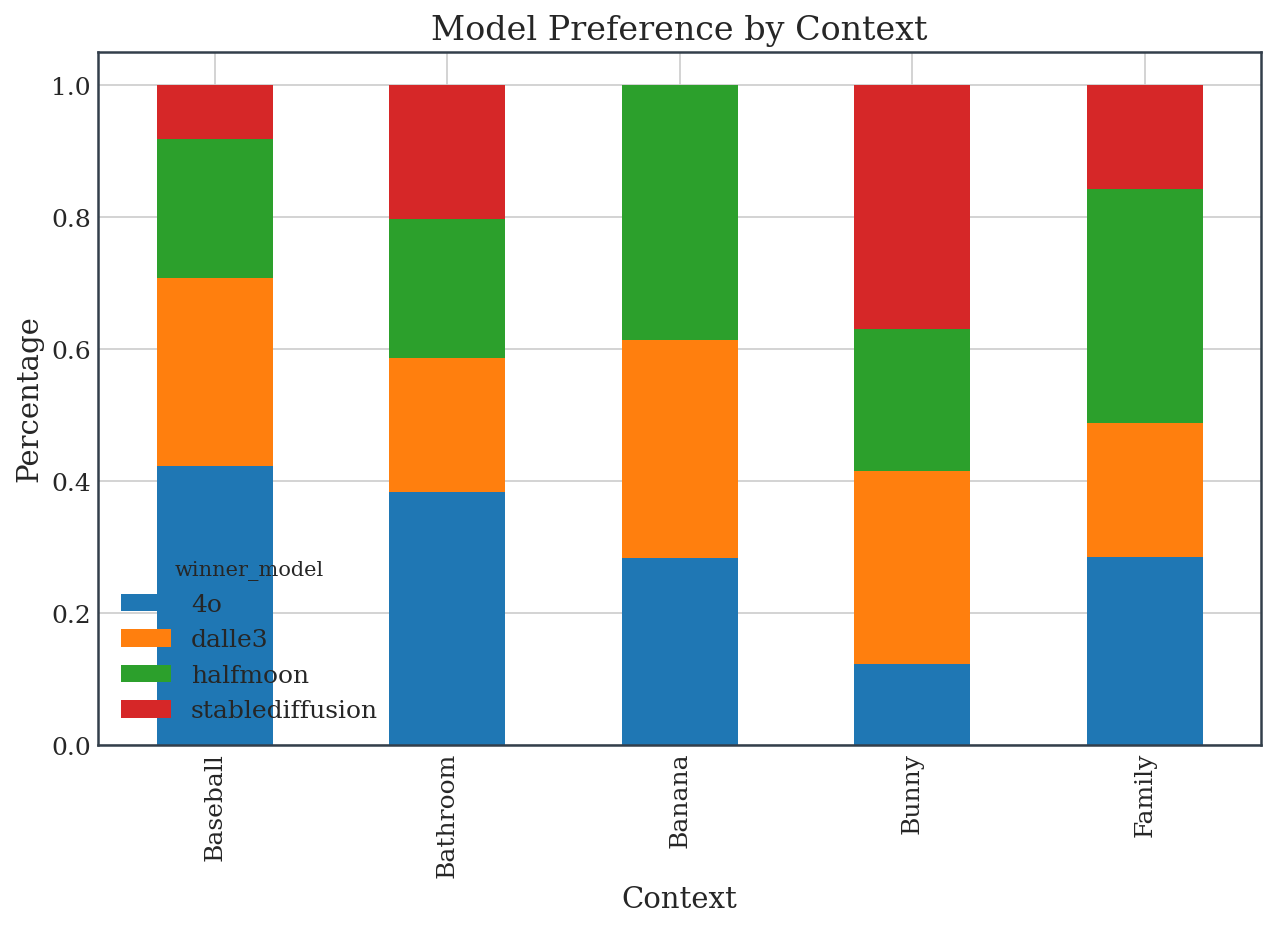

In [22]:
pivoted.plot(
    x = "context_summary",
    kind = "bar",
    stacked = True,
    title = "Model Preference by Context",
    xlabel = "Context",
    ylabel = "Percentage",
    figsize = (10, 6),
    legend = True,
    fontsize = 12
)

Interestingly, for the banana image, the stable diffusion model was never selected as the preferred one.

In [23]:
# preferred model by age group

age_group_counts = (
    df_exploded
    .groupby(['userDetails.age', 'winner_model'])  # both grouping keys here
    .size()
    .reset_index(name='count')
)

age_group_counts['percentage'] = (
    age_group_counts['count'] / age_group_counts.groupby(['userDetails.age'])['count'].transform('sum')
)

In [24]:
age_group_counts

,userDetails.age,winner_model,count,percentage
0,0-17,4o,21,0.283784
1,0-17,dalle3,18,0.243243
2,0-17,halfmoon,21,0.283784
3,0-17,stablediffusion,14,0.189189
4,18-29,4o,25,0.240385
5,18-29,dalle3,30,0.288462
6,18-29,halfmoon,30,0.288462
7,18-29,stablediffusion,19,0.182692
8,30-39,4o,26,0.337662
9,30-39,dalle3,21,0.272727


<Axes: xlabel='userDetails.age'>

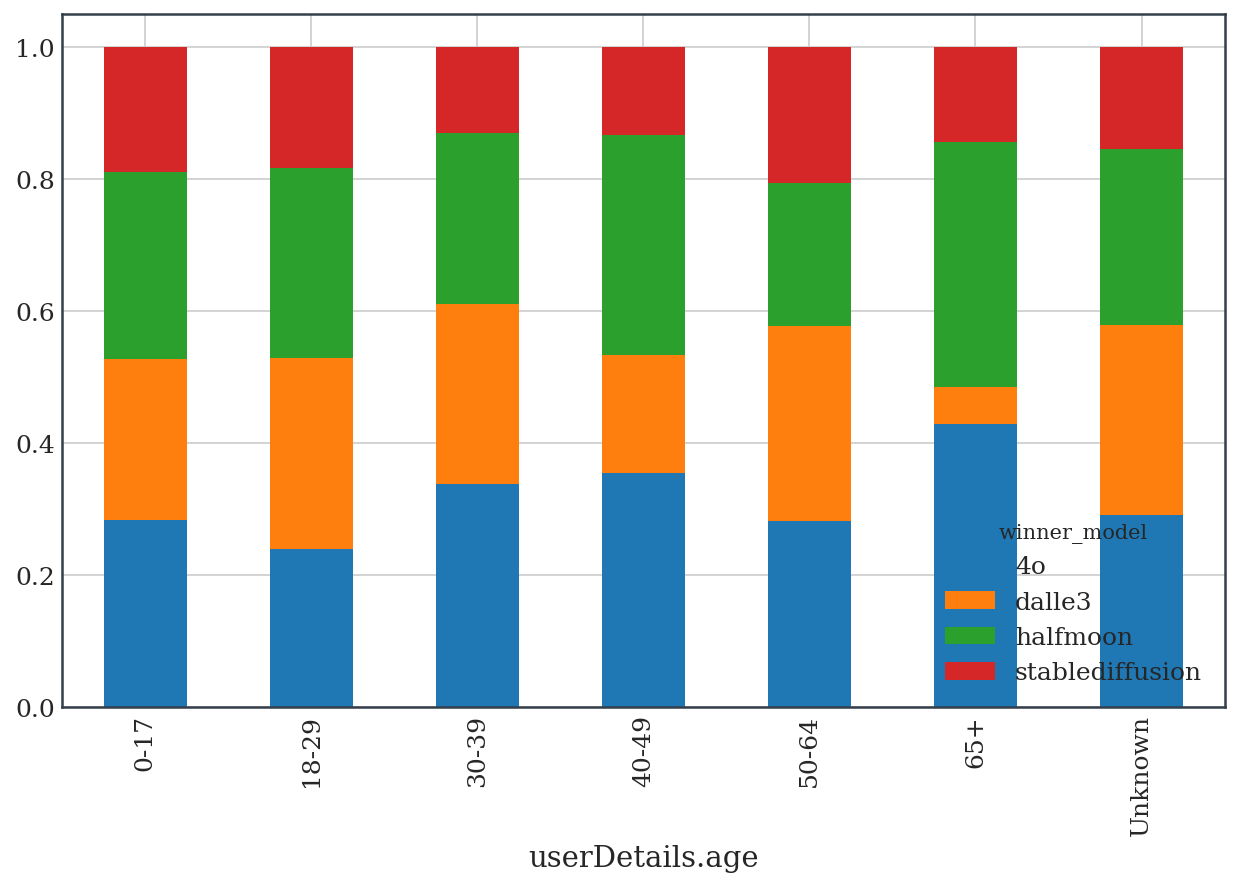

In [25]:
# plot the preferred model by age group
age_group_counts_pivoted = age_group_counts.pivot(index="userDetails.age", columns="winner_model", values="percentage")

# plot
age_group_counts_pivoted.plot(kind='bar', stacked=True, figsize=(10, 6))

In [26]:
# age group distribution by context

age_group_counts_by_context = (
    df_exploded
    .groupby(['context', 'userDetails.age'])  # both grouping keys here
    .size()
    .reset_index(name='count')
)

age_group_counts_by_context['percentage'] = (
    age_group_counts_by_context['count'] / age_group_counts_by_context.groupby(['context'])['count'].transform('sum')
)

In [27]:
age_group_counts_by_context

,context,userDetails.age,count,percentage
0,A baseball player in a blue and white uniform ...,0-17,13,0.105691
1,A baseball player in a blue and white uniform ...,18-29,19,0.154472
2,A baseball player in a blue and white uniform ...,30-39,12,0.097561
3,A baseball player in a blue and white uniform ...,40-49,6,0.048780
4,A baseball player in a blue and white uniform ...,50-64,19,0.154472
5,A baseball player in a blue and white uniform ...,65+,6,0.048780
6,A baseball player in a blue and white uniform ...,Unknown,48,0.390244
7,A bathroom with green tile and a red shower cu...,0-17,14,0.105263
8,A bathroom with green tile and a red shower cu...,18-29,17,0.127820
9,A bathroom with green tile and a red shower cu...,30-39,23,0.172932


In [28]:
# model preference by context and gender

preferences_by_gender = (
    df_exploded
    .groupby(['winner_model', 'userDetails.gender'])  # both grouping keys here
    .size()
    .reset_index(name='count')
)

preferences_by_gender['percentage'] = (
    preferences_by_gender['count'] / preferences_by_gender.groupby(['winner_model'])['count'].transform('sum')
)

In [29]:
preferences_by_gender

,winner_model,userDetails.gender,count,percentage
0,4o,Female,40,0.207254
1,4o,Male,51,0.264249
2,4o,Other,32,0.165803
3,4o,Unknown,70,0.362694
4,dalle3,Female,50,0.295858
5,dalle3,Male,31,0.183432
6,dalle3,Other,21,0.124260
7,dalle3,Unknown,67,0.396450
8,halfmoon,Female,41,0.230337
9,halfmoon,Male,40,0.224719


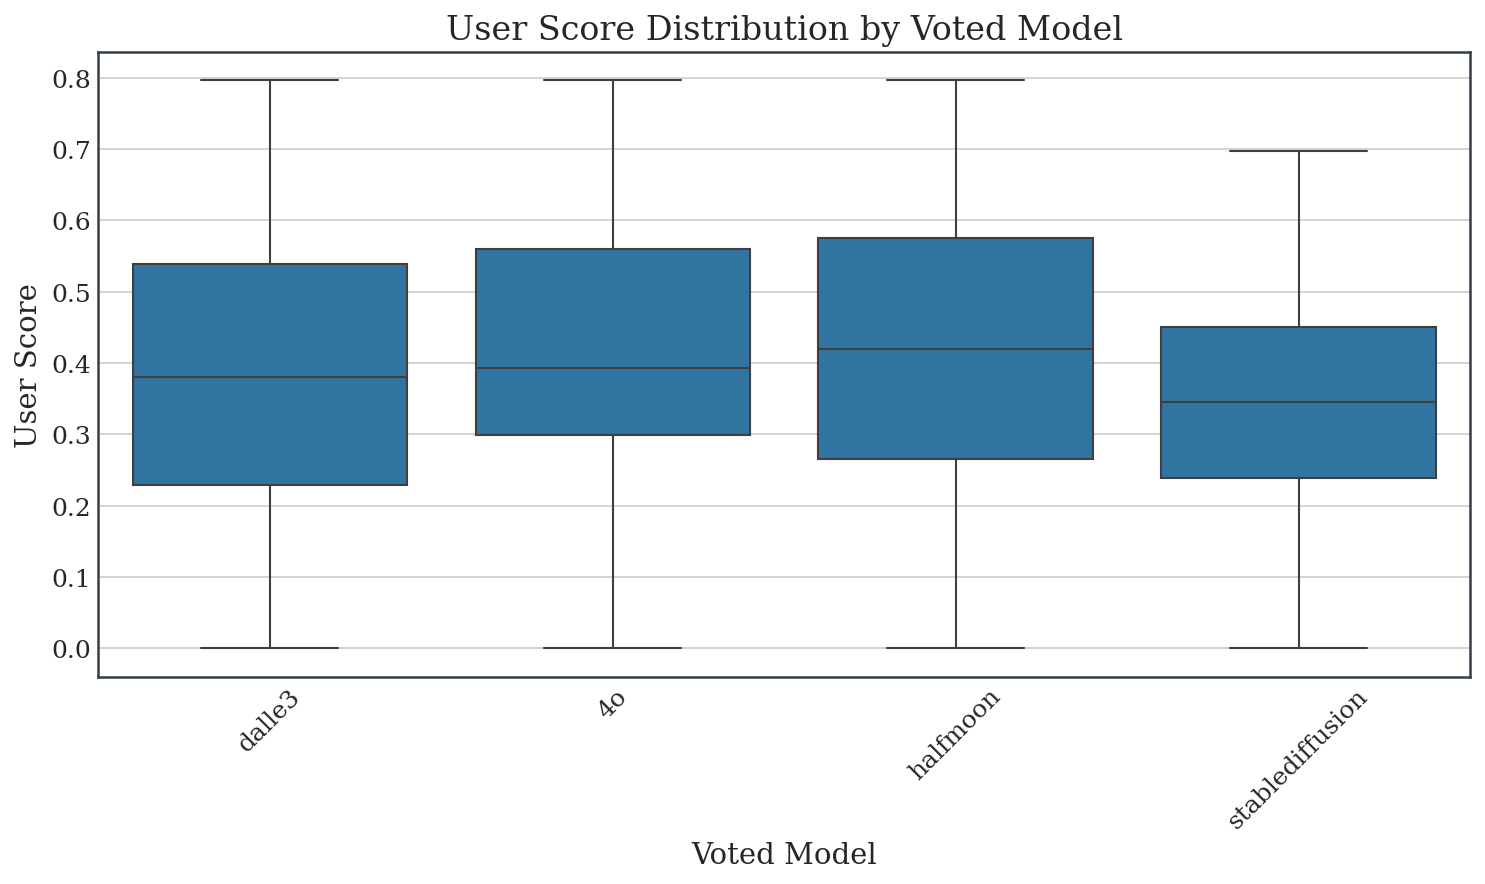

In [30]:
# boxplot of score by voted model

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_exploded, x="voted_for_model", y="userDetails.userScore")
plt.title("User Score Distribution by Voted Model")
plt.xlabel("Voted Model")
plt.ylabel("User Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# number of different countries
df_exploded["userDetails.country"].nunique()

36

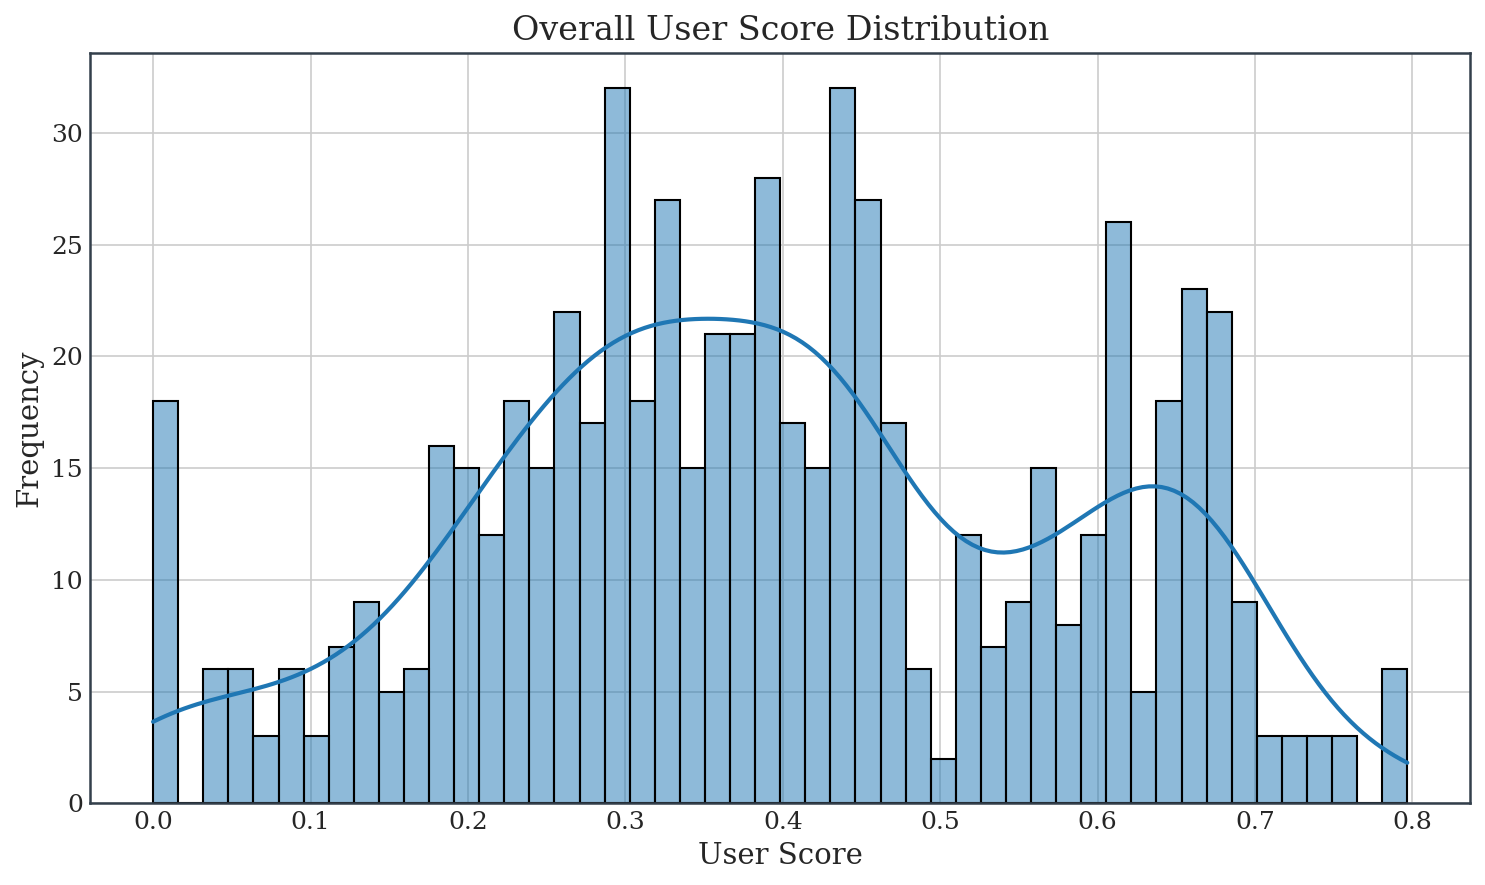

In [32]:
# histogram overall score distribution

plt.figure(figsize=(10, 6))
sns.histplot(df_exploded["userDetails.userScore"], bins=50, kde=True)
plt.title("Overall User Score Distribution")
plt.xlabel("User Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [33]:
# count of different countries

country_counts = df_exploded["userDetails.country"].value_counts()
country_counts

userDetails.country
IN         182
EG          76
RU          58
TR          38
DZ          36
RS          34
DE          29
PH          21
LY          18
IT          18
BR          12
FR          10
TZ           9
ES           9
AU           8
ID           8
BO           6
UA           6
KE           6
MZ           6
MY           6
VN           6
PK           6
BD           6
KZ           3
AO           3
MA           3
AT           3
AZ           3
PL           3
CD           3
unknown      3
PY           3
TN           2
BF           2
ET           1
Name: count, dtype: int64

In [34]:
# age group counts

age_group_counts = df_exploded["userDetails.age"].value_counts()

age_group_counts

userDetails.age
Unknown    233
18-29      104
50-64       78
30-39       77
0-17        74
40-49       45
65+         35
Name: count, dtype: int64

In [35]:
# model preference by age group
age_group_preferences = (
    df_exploded
    .groupby(['userDetails.age', 'winner_model'])  # both grouping keys here
    .size()
    .reset_index(name='count')
)

age_group_preferences['percentage'] = (
    age_group_preferences['count'] / age_group_preferences.groupby(['userDetails.age'])['count'].transform('sum')
)

age_group_preferences

,userDetails.age,winner_model,count,percentage
0,0-17,4o,21,0.283784
1,0-17,dalle3,18,0.243243
2,0-17,halfmoon,21,0.283784
3,0-17,stablediffusion,14,0.189189
4,18-29,4o,25,0.240385
5,18-29,dalle3,30,0.288462
6,18-29,halfmoon,30,0.288462
7,18-29,stablediffusion,19,0.182692
8,30-39,4o,26,0.337662
9,30-39,dalle3,21,0.272727


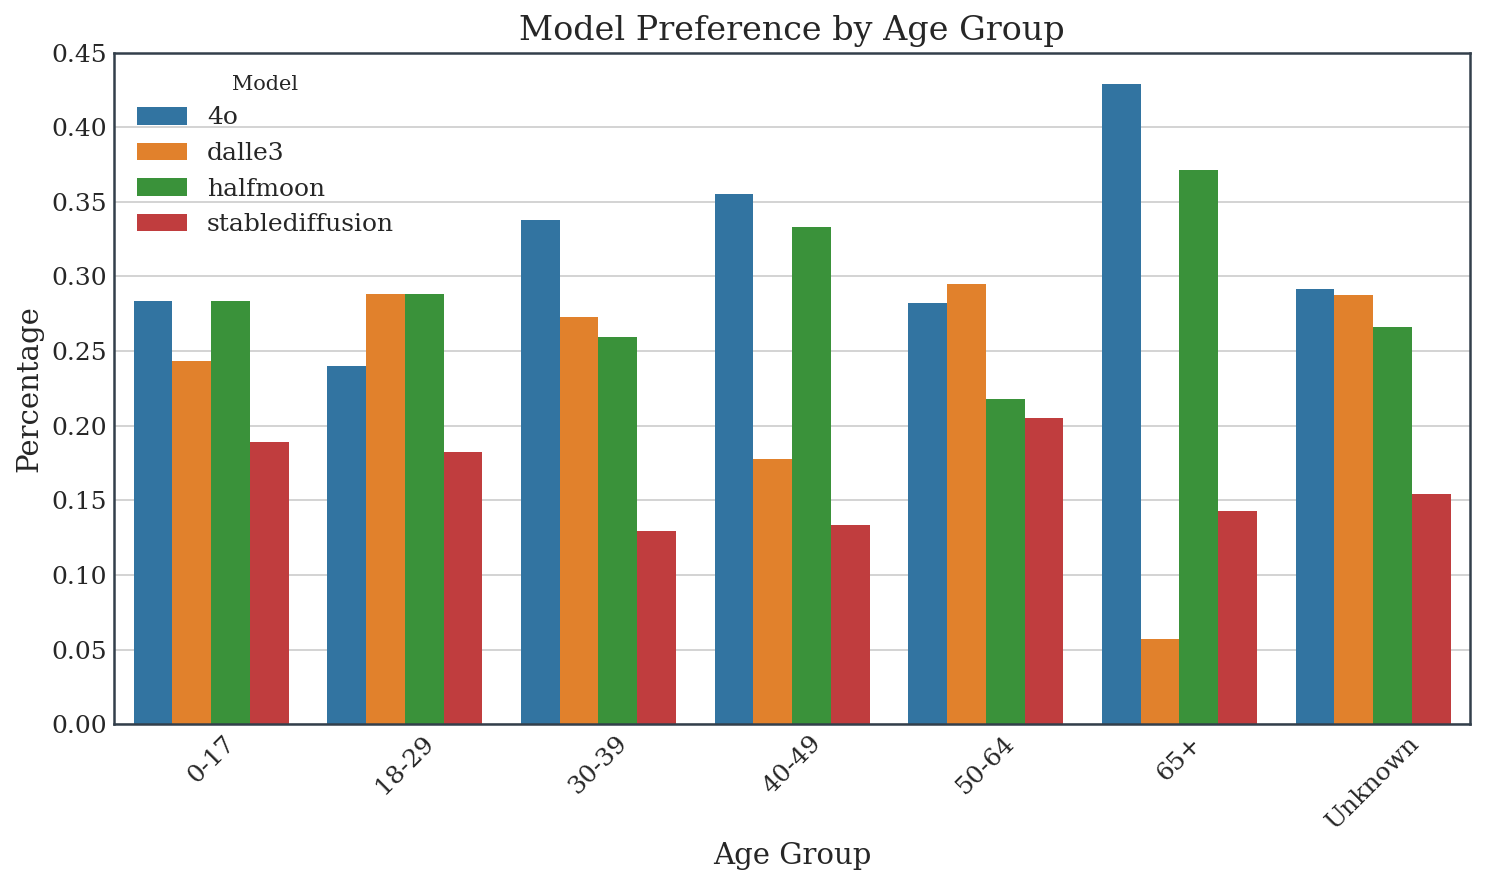

In [36]:
# plot of age preferences by age group

plt.figure(figsize=(10, 6))
sns.barplot(data=age_group_preferences, x="userDetails.age", y="percentage", hue="winner_model")
plt.title("Model Preference by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()

In [37]:
# Model preference by continent

df_exploded["continent"] = df_exploded["userDetails.country"].apply(lambda x: country_code_to_continent(x))

continent_counts = (
    df_exploded
    .groupby(['continent', 'winner_model'])  # both grouping keys here
    .size()
    .reset_index(name='count')
)

continent_counts['percentage'] = (
    continent_counts['count'] / continent_counts.groupby(['continent'])['count'].transform('sum')
)

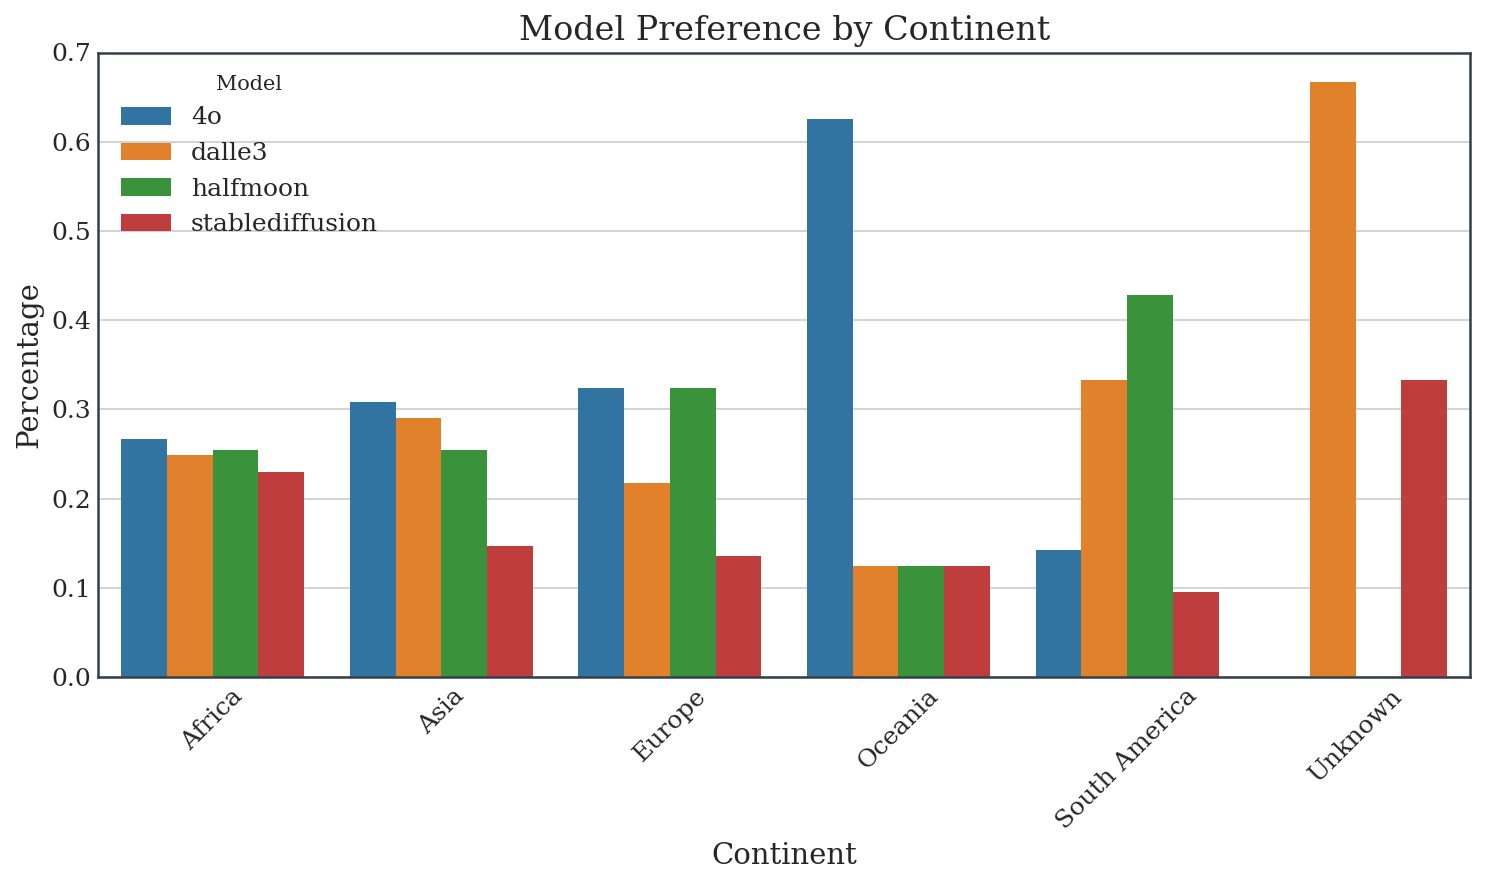

In [38]:
# plot of model preference percentage by continent

plt.figure(figsize=(10, 6))
sns.barplot(data=continent_counts, x="continent", y="percentage", hue="winner_model")
plt.title("Model Preference by Continent")
plt.xlabel("Continent")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()

**Exploratory data analysis summary:**

- Overall the preferred model seems to be OpenAI 4o, with results that are consistent throughout the different prompts and user demographics, though there is more variation when taking into consideration the different continents. 

## 2. Modelling

#### 2.1 Probability of vote correctness

So far we have seen how differet user characteristics affect their choice of preferred model.

Now, we try to model whether a user voted correctly or not. In order to determine whether a vote is correct or not, we define a dummy variable, which determines if a user voted for the model that ended up winning. This way we define a prediction to be correct if it agrees with the majority vote for a particular pairwise comparison (assuming that the majority of people vote correctly).

We assign a label of 0 if the user chose the winning model and 1 if they chose the losing model. This way we formulate the problem as predicting the probability that someone will vote wrongly (where by wrongly we mean they choose the model which was not preferred by the majority of users).

In [44]:
df_modelling = deepcopy(df_exploded)

In [45]:
df_modelling[0:2]

,context,winner_index,winner,votedFor,userDetails.country,userDetails.language,userDetails.userScore,userDetails.age,userDetails.gender,userDetails.occupation,model1,model2,winner_model,voted_for_model,continent
0,A blue bunny in a pink water toilet bowl.,1,dalle3_bunny.jpg,dalle3_bunny.jpg,ES,es,0.6753,18-29,Female,Unknown,4o,dalle3,dalle3,dalle3,Europe
1,A blue bunny in a pink water toilet bowl.,1,dalle3_bunny.jpg,dalle3_bunny.jpg,EG,ar,0.4068,40-49,Other,Education,4o,dalle3,dalle3,dalle3,Africa


In [46]:
y = (df_modelling["votedFor"] != df_modelling["winner"]).astype(int)

In [47]:
df_modelling.to_csv("data/modelling/df_modelling_original.csv", index=False)

Creation of train-test split

In [48]:
X_train, X_test, y_train, y_test = train_test_split_stratified(df_modelling, y, test_size=0.2)

In [49]:
print(type(X_train))
print(type(X_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [49]:
# feature processing

columns_to_drop = ["context", "winner_index", "winner", "votedFor", "model1", "model2", "voted_for_model", "userDetails.country", "userDetails.language"]
categorical_columns = [column for column in df_modelling.columns if column not in ["userDetails.userScore"] + columns_to_drop]


categorical_transformer = create_column_transformer(categorical_columns, []) # second argument empty as we don't process numerical columns

In [50]:
column_dropper = ColumnDropper(columns_to_drop=columns_to_drop)

In [51]:
X_train, X_test = column_dropper.transform(X_train), column_dropper.transform(X_test)

In [52]:
logreg_pipe = Pipeline([
    ("preprocessing", categorical_transformer),
    ("classifier", SGDClassifier(loss="log_loss", max_iter=1000, random_state=42))
])

rf_pipe = Pipeline([
    ("preprocessing", categorical_transformer),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

nb_pipe = Pipeline(steps=[
    ("preprocessing", categorical_transformer),
    ("classifier", CategoricalNB())
])

catboost_model = CatBoostClassifier(verbose=0, random_state=42)

In [53]:
models = [logreg_pipe, rf_pipe, catboost_model, nb_pipe]
model_names = ["Logistic Regression", "Random Forest", "CatBoost", "Naive Bayes"]
results = {}

In [54]:
for model, name in zip(models, model_names):
    if isinstance(model, CatBoostClassifier):
        train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
        test_pool = Pool(X_test, y_test, cat_features=categorical_columns)
        model.fit(train_pool)
        y_probs = model.predict_proba(test_pool)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_probs = model.predict_proba(X_test)[:, 1]
    
    results[name] = evaluate_model(model, X_test, y_test)
        

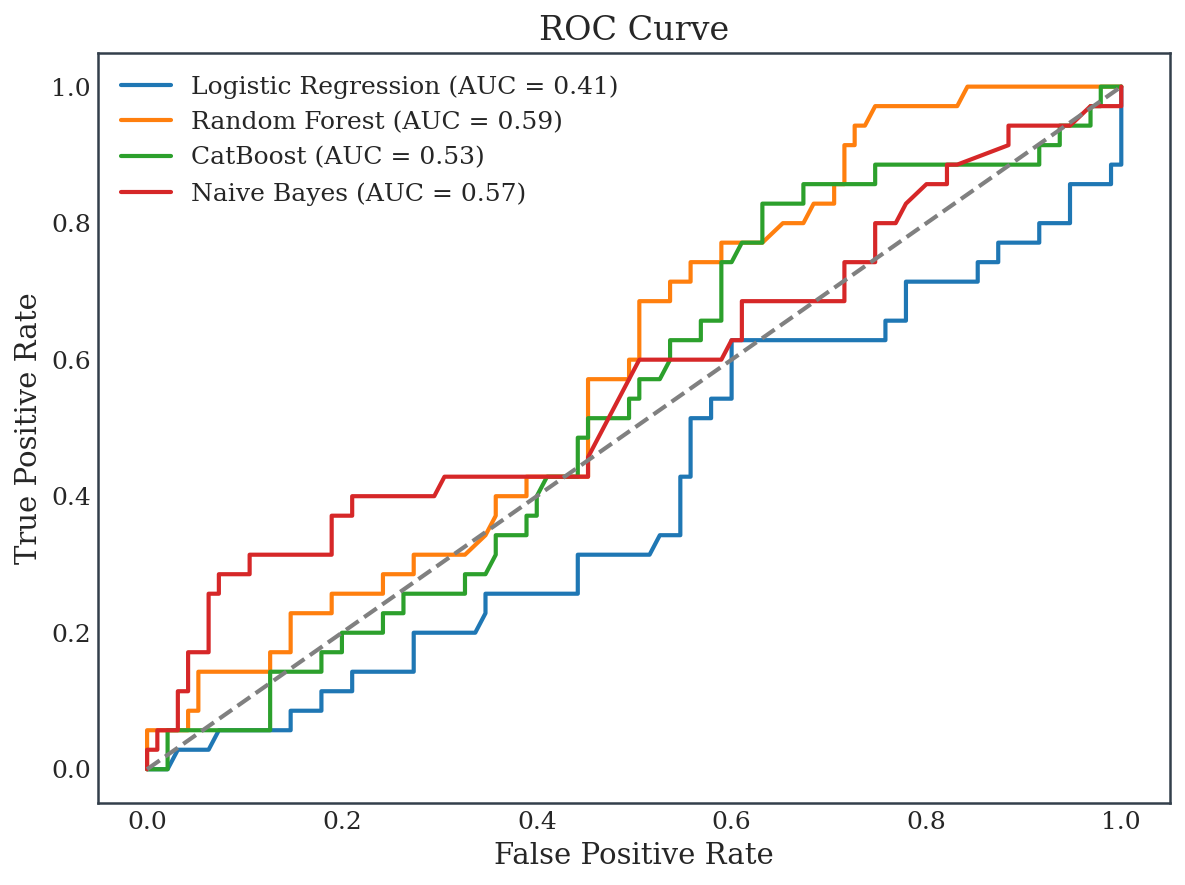

In [55]:
plot_roc_curves(results)

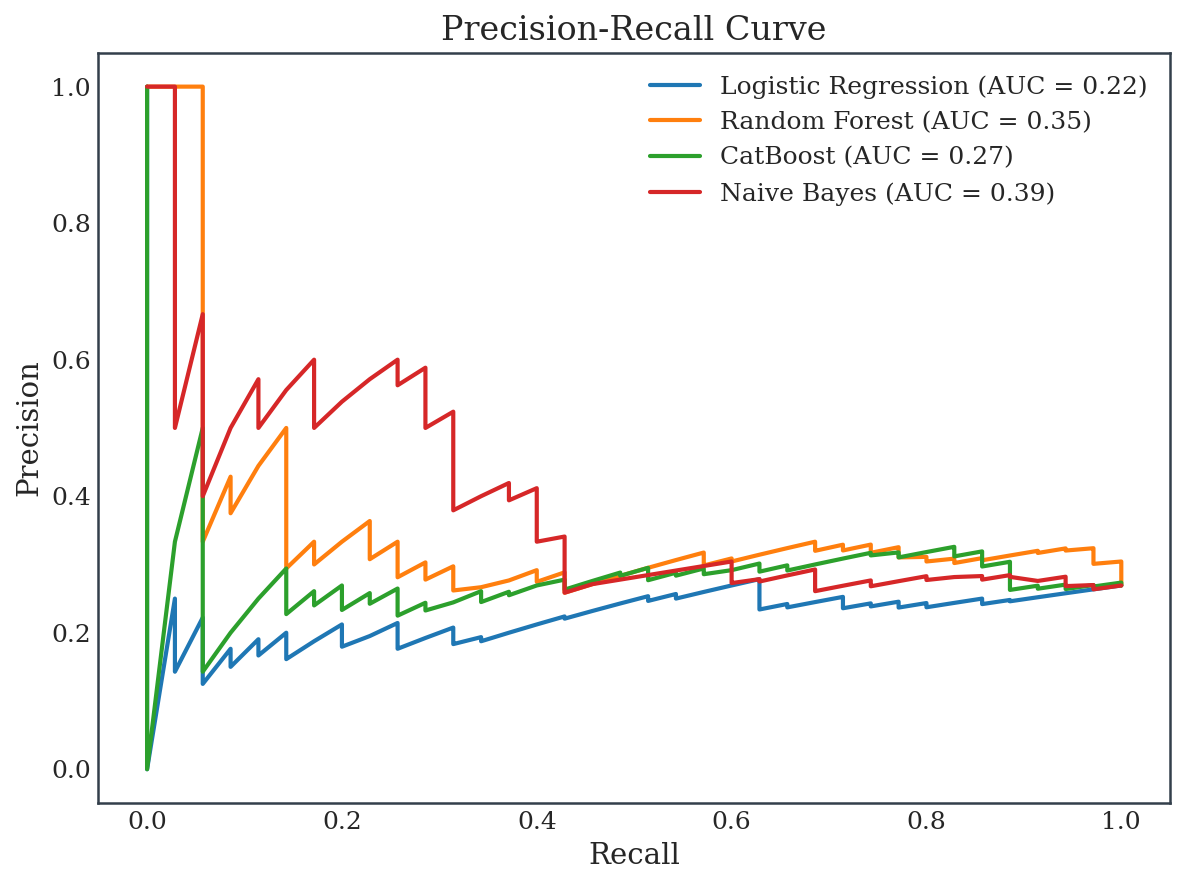

In [56]:
plot_pr_curves(results)

**Comments on modelling the correct classification probability**

- The results from the models are underwhelming. This is to be expected, mainly as we took into consideration only a few prompts, from a small number of models, and the overall quality of the images is somewhat similar (with the exception of some of the images generated by Stable Diffusion). 
- The variables collected do not seem to be informative enough to predict the correctness of a vote. This could be solved by collecting more data, or by (ideally) using a different set of features.

#### 2.2 Model Comparison via Bradley-Terry 

Estimation of a Bradley-Terry model to predict which model will win when doing pairwise comparisons of images

In [57]:
df_exploded

,context,winner_index,winner,votedFor,userDetails.country,userDetails.language,userDetails.userScore,userDetails.age,userDetails.gender,userDetails.occupation,model1,model2,winner_model,voted_for_model,continent
0,A blue bunny in a pink water toilet bowl.,1,dalle3_bunny.jpg,dalle3_bunny.jpg,ES,es,0.6753,18-29,Female,Unknown,4o,dalle3,dalle3,dalle3,Europe
1,A blue bunny in a pink water toilet bowl.,1,dalle3_bunny.jpg,dalle3_bunny.jpg,EG,ar,0.4068,40-49,Other,Education,4o,dalle3,dalle3,dalle3,Africa
2,A blue bunny in a pink water toilet bowl.,1,dalle3_bunny.jpg,dalle3_bunny.jpg,RS,sr,0.7039,50-64,Male,Education,4o,dalle3,dalle3,dalle3,Europe
3,A blue bunny in a pink water toilet bowl.,1,dalle3_bunny.jpg,4o_bunny.jpg,BO,es,0.3385,0-17,Other,Other Employment,4o,dalle3,dalle3,4o,South America
4,A blue bunny in a pink water toilet bowl.,1,dalle3_bunny.jpg,4o_bunny.jpg,RS,sr,0.3717,40-49,Female,Unemployed or Student,4o,dalle3,dalle3,4o,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,A black colored banana.,0,halfmoon_banana.jpg,halfmoon_banana.jpg,ES,es,0.6997,18-29,Female,Unknown,halfmoon,stablediffusion,halfmoon,halfmoon,Europe
642,A black colored banana.,0,halfmoon_banana.jpg,halfmoon_banana.jpg,RU,ru,0.6593,65+,Other,Unknown,halfmoon,stablediffusion,halfmoon,halfmoon,Europe
643,A black colored banana.,0,halfmoon_banana.jpg,halfmoon_banana.jpg,DZ,en,0.6654,Unknown,Unknown,Unknown,halfmoon,stablediffusion,halfmoon,halfmoon,Africa
644,A black colored banana.,0,halfmoon_banana.jpg,stablediffusion_banana.jpg,IN,en,0.3982,Unknown,Unknown,Unknown,halfmoon,stablediffusion,halfmoon,stablediffusion,Asia


In [70]:
bradley_terry = BradleyTerry()

bradley_terry.fit(df_exploded, model1_column="model1", model2_column="model2", outcome_column="winner_model")

bradley_terry.p

{'4o': np.float64(6137847439.054609),
 'dalle3': np.float64(360144.6854355642),
 'stablediffusion': np.float64(0.0),
 'halfmoon': np.float64(14.224556849691623)}

In [72]:
bradley_terry.rank()

[('4o', np.float64(6137847439.054609)),
 ('dalle3', np.float64(360144.6854355642)),
 ('halfmoon', np.float64(14.224556849691623)),
 ('stablediffusion', np.float64(0.0))]

In [78]:
bradley_terry.predict("dalle3", "4o")

np.float64(5.867261419922948e-05)

**Comments on Bradley-Terry model**

- As we can see from the table, the model with the highest probability of winning is the 4o model, which is consistent with our previous analysis. The model with the lowest probability of winning is the stable diffusion model, which is also consistent with our previous analysis.

---

Some final thoughts

Overall, the main goal of this analysis was to perform two example tasks which might be relevant to Rapidata. Namely, the first task was to predict whether a user will vote correctly or not, and the second task was to rank the models based on their performance. The results of the first model are somewhat underwhelming, but this is to be expected given the small size of the dataset and the limited number of features.

The models were implemented trying to follow best practices, and mimicking what would be done in a production environment. The code is modular and can be easily extended to include more features or to use different models. The data is stored in a structured way, and the analysis is performed using standard libraries such as pandas and scikit-learn.